# Language Identification Model


In [31]:
### TO DEBUGGIN'
_DEBUG = True

## Load Package

In [94]:
# to load and manipulate data
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split

# to make neural netowrk model, sequencing and tokenizing
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# to evaluate and display results
from sklearn.metrics import  confusion_matrix, accuracy_score
import matplotlib
import matplotlib.pyplot as plt

# to graph
import squarify

## Load Data

In [33]:
## print paths
for root, dirs, files in os.walk('./data'):
    for filename in files:
        print(os.path.join(root,filename))
del dirs
del root
del files
del filename

./data/language.json
./data/sentences.csv


In [55]:
%%time
## vamos a medir el TIME de esta shit

df = pd.read_csv("./data/sentences.csv")

CPU times: user 5.69 s, sys: 656 ms, total: 6.35 s
Wall time: 6.55 s


## Data Cleansing

In [56]:
## eliminar columna maldita que esta de mas ID
df.drop(columns=['id'],inplace=True)

In [57]:
df.head()

,lan_code,sentence
0,cmn,我們試試看！
1,cmn,我该去睡觉了。
2,cmn,你在干什麼啊？
3,cmn,這是什麼啊？
4,cmn,今天是６月１８号，也是Muiriel的生日！


In [58]:
if _DEBUG:
    display(df.describe())

,lan_code,sentence
count,10341812,10341812
unique,404,10330761
top,eng,Bravo!
freq,1586621,11


Code LANGUAGE with less frequency than 10: sentence    277
dtype: int64


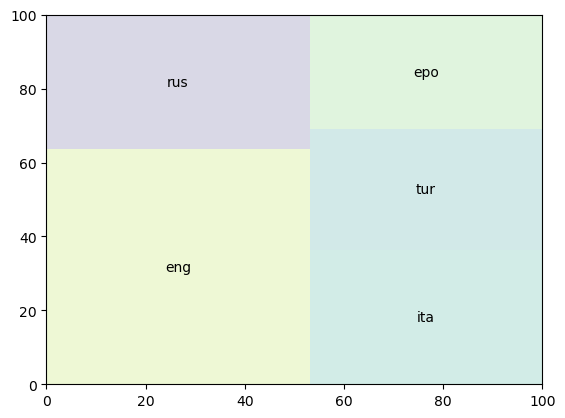

In [59]:
if _DEBUG:
    df_exploration = df.groupby("lan_code").count().sort_values("sentence",ascending = False)

    #!# posiblemente cuando se entrene el modelo los de baja frecuencia no va a predecir correctamente
    #!# como posible opcion 1 analizar con todo y luego ver el impacto de remover esos code lan con freq 1
    
    count_freq_1 = df_exploration[df_exploration.sentence<=10].sum()
    print("Code LANGUAGE with less frequency than 10: {}".format(count_freq_1))
    
    ## GRAPH - TREEMAP
    # top 50 Language with more sentences
    sizes_treemap = df_exploration["sentence"][:5].tolist()
    labels_treemap = df_exploration[:5].index.values.tolist()
    
    #plt.figure(figsize=(10,10))
    squarify.plot(sizes = sizes_treemap, label = labels_treemap, alpha=0.2)
    plt.savefig('/Users/pitehrhurtadocayo/Documents/DevOps/Project_0006_NLP/NLP_LanguageIdentification/outputs/heatmap_lan.png')
    plt.show()
    list_lan_top_10 = df_exploration[:5].index.tolist()

    del df_exploration
    del count_freq_1
    del sizes_treemap
    del labels_treemap

## Preprocessing Data


In [60]:
## Filter TOP 30 Lan
df = df[df["lan_code"].isin(list_lan_top_10)] 

# ENCODING CLASSES (cod language)
classes_list = list(df.lan_code.unique())
print("Count of Classes: {}".format(len(classes_list)))

Count of Classes: 5


In [61]:
## crearemos dos dic para usos posteriores de transformacion
cls_to_num = {
    cls : i
    for i,cls in enumerate(classes_list)
}

num_to_cls = {
    i : cls
    for cls,i in cls_to_num.items()
}

In [62]:
## cambiar el string-code por int-code para ingresarlos al modelo
display(df.head())
df.lan_code = df.lan_code.map(cls_to_num).astype(int)
display(df.head())

,lan_code,sentence
235,rus,Один раз в жизни я делаю хорошее дело... И оно...
1232,eng,Let's try something.
1233,eng,I have to go to sleep.
1235,eng,Today is June 18th and it is Muiriel's birthday!
1236,eng,Muiriel is 20 now.


,lan_code,sentence
235,0,Один раз в жизни я делаю хорошее дело... И оно...
1232,1,Let's try something.
1233,1,I have to go to sleep.
1235,1,Today is June 18th and it is Muiriel's birthday!
1236,1,Muiriel is 20 now.


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4705216 entries, 235 to 10341806
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   lan_code  int64 
 1   sentence  object
dtypes: int64(1), object(1)
memory usage: 107.7+ MB


## Subset Train & Test

In [64]:
# Lista de Sentencias
X = df.pop('sentence').values

# Lista de CODE LAN 
y = df.copy().values.T[0]

if _DEBUG:
    display(X)
    display(y)

array(['Один раз в жизни я делаю хорошее дело... И оно бесполезно.',
       "Let's try something.", 'I have to go to sleep.', ...,
       'Kial forigi la bovinon de la glacio, kiam estis sufiĉe malfacile, aldoni ĝin tien?',
       'La plej malfacila parto de la maratono estas la maratono mem.',
       'Kio estus la vivo, se ni ne havus la kuraĝon riski ion?'],
      dtype=object)

array([0, 1, 1, ..., 3, 3, 3])

In [65]:
## liberamos memoria virtual (RAM)
del df

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    train_size=0.8,
    random_state=50,
    shuffle = True
)

## liberamos memoria virtual (RAM)
del X, y

# Tokenization

Usaremos este metodo para procesar los datos input para el modelo:

mas info: https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4


### Sentencias -> Secuencias de palabras


In [67]:
## parametros

NUM_WORDS = 100000
MAX_LEN = 100
NUM_CLASSES = 5 # esto lo sacamos de arriba

In [68]:
def tokenize_and_sequence(
                            train_sentences,
                            test_sentences
                            ):
    tok = Tokenizer(num_words = NUM_WORDS, oov_token='<OOV>')
    tok.fit_on_texts(train_sentences)
    
    # training set
    train_seq = tok.texts_to_sequences(train_sentences)
    train_seq = pad_sequences(
                    train_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    
    # testing set
    test_seq = tok.texts_to_sequences(test_sentences)
    test_seq = pad_sequences(
                    test_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    if _DEBUG:
        print(tok.get_config())
    
    return train_seq, test_seq, tok

In [69]:
%%time
## call function 
X_train, X_test, tok = tokenize_and_sequence(X_train, X_test)

# WARNING: problemas de tiempo de respuesta, se debe cambiar la config del notebook

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
if _DEBUG:
    print(X_train.shape)
    print(X_test.shape)

(3764172, 100)
(941044, 100)


# Model NLP

## Build Model

- Embedding layer son capas de palabras previamente entrenadas como GloVe, se usan mucho en NLP.
- LSTM : capa de memoria a largo plazo
- Dense: capa densa conectada normal
- Dropout: ayuda a evitar el sobreajuste en la entrada

Funciones de Activacion: https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6

Ocupamos:
- ReLu
- Softmax: se usa muy amenudo en la ultima capa de la red, como FA. dado que el resultado se podria interpretar como una D. P. 

In [71]:
## heredamos la clases tf.keras.model (Classic)
class NLPModel(tf.keras.Model):
    def __init__(self,
                vocad_dim = NUM_WORDS,
                max_len = MAX_LEN,
                num_classes = NUM_CLASSES):
        super().__init__()
        
        self.embedding = layers.Embedding(input_dim = vocad_dim, output_dim = 32, input_length = max_len)
        
        self.lstm1 = layers.Bidirectional(layers.LSTM(units = 32, return_sequences=True))
        self.lstm2 = layers.Bidirectional(layers.LSTM(16))
        
        self.dense = layers.Dense(64, activation = 'relu')
        
        self.dropout = layers.Dropout(0.5)
        
        self.classifier = layers.Dense(num_classes, activation = 'softmax')
        
    def call(self, inputs, training = False):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training = training)
        return self.classifier(x)

In [72]:
model = NLPModel()

In [73]:
## Especificamos la configuración de entrenamiento (optimizador, pérdida, métricas):
# uso de ADAM Algorithm

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Train Model

In [76]:
%%time
history = model.fit(
                    X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=100, 
                    epochs=1
)

37642/37642 [==============================] - 2219s 59ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0049 - val_accuracy: 0.9983
CPU times: user 1h 12min 4s, sys: 13min 1s, total: 1h 25min 5s
Wall time: 36min 58s


In [97]:
## Training INFO
history.history
model.summary()

Model: "nlp_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  3200000   
                                                                 
 bidirectional_2 (Bidirectio  multiple                 16640     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  multiple                 10368     
 nal)                                                            
                                                                 
 dense_2 (Dense)             multiple                  2112      
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  

## Evaluate Model

In [78]:
%%time
y_pred = model.predict(X_test, batch_size=512, verbose=1)
y_pred = y_pred.argmax(axis=1)

1838/1838 [==============================] - 113s 61ms/step
CPU times: user 3min 54s, sys: 1min 20s, total: 5min 14s
Wall time: 1min 53s


In [79]:
%%time
acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_recall = confusion_matrix(y_test, y_pred, normalize='true')
conf_mat_precision = confusion_matrix(y_test, y_pred, normalize='pred')

CPU times: user 290 ms, sys: 19.2 ms, total: 309 ms
Wall time: 309 ms


### Accuracy

In [80]:
print(f"Accuracy = {acc:.2%}")

Accuracy = 99.83%


## Save Model H5

In [90]:
# cuando son modelos extendidos el formato h5 no aplica
#model.save('nlp_v1.h5')

# Save the weights
model.save_weights('model_weights/')

# Load Saved Model

In [98]:
def create_model():
  m = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])

  return m

In [101]:
new_model = NLPModel()
new_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Show the model architecture
new_model.load_weights('model_weights/')
new_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

# Prueba de APP


In [99]:
def app(phrase, _DEBUG = _DEBUG):
    phrase_seq = tok.texts_to_sequences(phrase)
    phrase_seq = pad_sequences(
                    phrase_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    if _DEBUG :
        print(phrase_seq)
    
    output = model.predict(phrase_seq, batch_size=512, verbose=1)
    list_results = {}
    for i in range(len(output[0])):
        if output[0][i]>=0.1:
            list_results[num_to_cls[i]] = output[0][i]

    return list_results, output

In [106]:
phrase = "habia una vez una persona sentada"
result, output = app(phrase)


[[11396     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]
 [ 5704     0     0 ...     0     0     0]
 ...
 [    3     0     0 ...     0     0     0]
 [    9     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]]
1/1 [==============================] - 0s 23ms/step


In [107]:
import operator
print(sorted(result.items(), key=operator.itemgetter(1), reverse=True))

[('eng', 0.34160417), ('deu', 0.10362743), ('fin', 0.10270908)]


In [105]:
with open("./data/language.json") as f:
    lan_to_language = json.load(f)
display(lan_to_language['kab'])

'Kabyle'

# Anexos

## confusion matrix

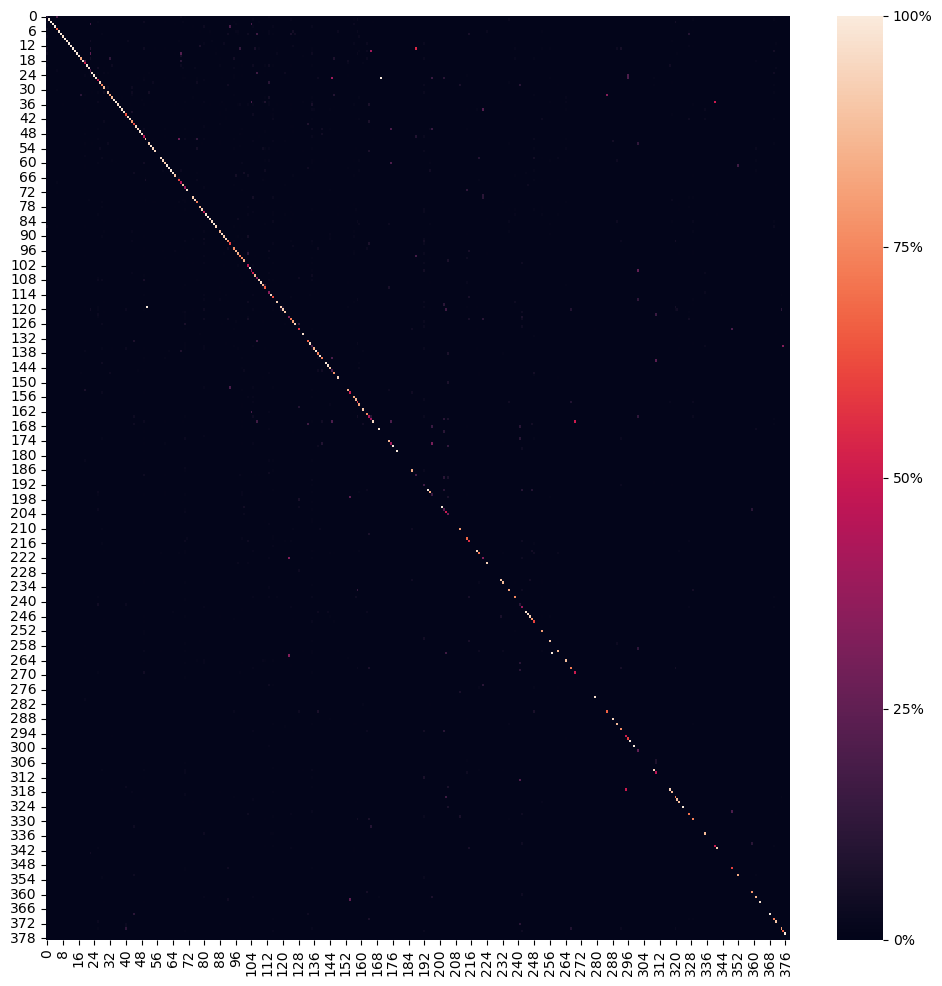

In [29]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(conf_mat_precision, vmin=0, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.show()